### 統計學習與深度學習 Homework 4

In [6]:
#load packages
import torch
import pickle
import numpy as np
from sklearn import preprocessing

#Load data
with open('data/msd_full.pickle', 'rb') as fh1:
    msd_data = pickle.load(fh1)

X_train = msd_data['X_train']
X_test = msd_data['X_test']

Y_train = msd_data['Y_train']
Y_test = msd_data['Y_test'].astype('float32')
X_test = X_test.astype('float32')


print("X_train shape = ", X_train.shape)
print("Y_train shape = ", Y_train.shape)

print("X_test shape = ", X_test.shape)

X_train shape =  (463715, 90)
Y_train shape =  (463715,)
X_test shape =  (51630, 90)


### Q1. OLS

使用現有的OLS model做training

In [7]:
import statsmodels.api as sm
np.set_printoptions(suppress=True)

#Q1 OLS
X_train_OLS = sm.add_constant(X_train)
model = sm.OLS(Y_train, X_train_OLS)
result = model.fit()
X_test_OLS = sm.add_constant(X_test)
Y_pred = result.predict(X_test_OLS)
RMSE_OLS = 0;

for i in range(Y_test.shape[0]):
	RMSE_OLS += (Y_pred[i]-Y_test[i])**2
RMSE_OLS = RMSE_OLS/Y_test.shape[0]
RMSE_OLS = RMSE_OLS**0.5

In [35]:
print("RMSE of OLS =", RMSE_OLS);
print(result.params[0:6])

RMSE of OLS = 9.510160685594299
[ 0.          5.30975265 -2.88088114 -1.53234348  0.05737583 -0.33952889]


由於題目要求OLS模型加入常數項，params的第一項為截距項，後面五項才是所要的前五個特徵參數

### data regularization, turn it to torch

In [24]:
xscaler = preprocessing.StandardScaler().fit(msd_data['X_train'])
#standardize feature values
X_train = xscaler.transform(msd_data['X_train'])
X_test = xscaler.transform(msd_data['X_test'])

y_mean = Y_train.mean()
Y_train_keep = Y_train.copy()
Y_test_keep = Y_test.copy()
Y_train = Y_train - y_mean
Y_test = Y_test - y_mean

#validation is the last 10% of training, subtraining is the first 90% of training
nvalid = int(X_train.shape[0] * 0.1)
nsubtrain = X_train.shape[0] - nvalid

X_subtrain = X_train[0:nsubtrain, :].astype('float32')
X_valid = X_train[nsubtrain:, :].astype('float32')
Y_subtrain = Y_train[0:nsubtrain].astype('float32')
Y_valid = Y_train[nsubtrain:].astype('float32')

Y_subtrain_keep = Y_train_keep[0:nsubtrain].astype('float32')
Y_valid_keep = Y_train_keep[nsubtrain:].astype('float32')

print("X_subtrain shape = ", X_subtrain.shape)
print("X_valid shape = ", X_valid.shape)
print("Y_subtrain shape = ", Y_subtrain.shape)
print("Y_valid shape = ", Y_valid.shape)

X_subtrain shape =  (417344, 90)
X_valid shape =  (46371, 90)
Y_subtrain shape =  (417344,)
Y_valid shape =  (46371,)


In [25]:
X_subtrain_torch = torch.FloatTensor(X_subtrain)
X_valid_torch = torch.FloatTensor(X_valid)
Y_subtrain_torch = torch.FloatTensor(Y_subtrain)
Y_valid_torch = torch.FloatTensor(Y_valid)
Y_subtrain_torch = torch.FloatTensor(Y_subtrain_keep)
Y_valid_torch = torch.FloatTensor(Y_valid_keep)
X_test_torch = torch.FloatTensor(X_test)
Y_test_torch = torch.FloatTensor(Y_test)

In [9]:
from torch.utils import data

class Dataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, Xnp, Ynp):
        'Initialization, passing Xnp and Ynp'
        self.labels = Ynp
        self.nobs = Xnp.shape[0]        
        self.Xnp = Xnp
        self.Ynp = Ynp
  def __len__(self):
        'Denotes the total number of samples'
        return self.nobs
  def __getitem__(self, index):
        'Generates one sample of data'        
        X = self.Xnp[index]
        y = self.Ynp[index]
        return X, y
       
subtrainset = Dataset(X_subtrain, Y_subtrain)
validset = Dataset(X_valid, Y_valid)
testset = Dataset(X_test, Y_test)

In [11]:
print("subtrainset len = ", len(subtrainset))
print("validset len = ", len(validset))
print("testset len = ", len(testset))

subtrainset len =  417344
validset len =  46371
testset len =  51630


In [63]:
torch.manual_seed(0)
np.random.seed(0)
subtrainloader = data.DataLoader(subtrainset, batch_size=1000, shuffle=True, num_workers=0)
X_batch, Y_batch = next(iter(subtrainloader))
print("X_batch size:", X_batch.size())
print("y_batch size:", Y_batch.size())

X_batch size: torch.Size([1000, 90])
y_batch size: torch.Size([1000])


### Q2. MLP with Four Hidden Layers

依照題目要求，設定每100個batch記錄一次RMSE，batch size為1000。挑出並記錄模型中最優的valid rmse的狀態，將該狀態套用在test上，以計算最終的結果

In [12]:
H=45
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = "cuda"   
else:
    device = "cpu"
print("Running on device: ", device)
net = torch.nn.Sequential(
        torch.nn.Linear(90, H),  
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, 1),
)

# convert everything to float precision. 
net = net.float()
# move the model to device (i.e., cpu or gpu)
net = net.to(device)

Running on device:  cpu


In [13]:
class SSE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x, y):
        return torch.sum(torch.pow((x - y), 2))

In [14]:
# define the optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.00001)

loss_fn = SSE()

In [70]:
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

nepoch = 100
batch_cnt = 0
best_step_cnt = 0
early_stop = 0
best_rmse = math.inf
    
subtrain_rmse_list = []
valid_rmse_list = []

for epoch_id in range(0, nepoch): 
    for batch_idx, (inputs, targets) in enumerate(subtrainloader):
        #reshape target to two-dimensional array
        targets = targets.reshape((-1, 1))      
        net.train()
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)        
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        
        batch_cnt += 1
        best_step_cnt += 1
        if batch_cnt % 100 == 0:
            subtrain_pred = net(X_subtrain_torch)
            subtrain_rmse = np.sqrt(mean_squared_error(subtrain_pred.detach().numpy(), Y_subtrain_torch))
            subtrain_rmse_list.append(subtrain_rmse)
            valid_pred = net(X_valid_torch)
            valid_rmse = np.sqrt(mean_squared_error(valid_pred.detach().numpy(), Y_valid_torch))
            valid_rmse_list.append(valid_rmse)
            
            if valid_rmse < best_rmse:
                best_step_cnt = 0
                best_rmse = valid_rmse
                torch.save(net.state_dict(), './net/best_q2_H'+str(H)+'.pkl')
        if best_step_cnt > 5000:
            print("best step cnt while early stop = ", best_step_cnt)
            print("batch cnt while early stop = ", batch_cnt)
            early_stop = 1
            break
    if early_stop == 1:
        break
print("batch cnt = ", batch_cnt)

best step cnt while early stop =  5001
batch cnt while early stop =  10001
batch cnt =  10001


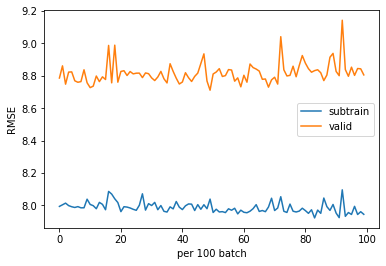

In [72]:
l = list(range(len(subtrain_rmse_list)))
plt.plot(l, subtrain_rmse_list, label='subtrain')
plt.plot(l, valid_rmse_list, label='valid')
plt.xlabel("per 100 batch")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [73]:
net.load_state_dict(torch.load('./net/best_q2_H45.pkl'))
net.eval()
test_pred = net(X_test_torch)
test_rmse = np.sqrt(mean_squared_error(test_pred.detach().numpy(), Y_test_torch))

print("H = 45, test RMSE = ", test_rmse)

H = 45, test RMSE =  8.967344


從圖形來觀察，subtrain RMSE有隨著per 100 batch增加而略微減少的趨勢，但valid RMSE沒有明顯下降，而是呈現上下波動的狀態。雖然training RMSE仍在下降，但valid RMSE卻沒有更好，繼續train會導致overfitting使得預測效果更差，因此透過early stopping的機制，提前終止迴圈並且保留最好的模型參數。

### Q3. MLP with different H

調整H，重新做與Q2相同的事

In [69]:
H = 90
batch_cnt = 0
best_step_cnt = 0
early_stop = 0
best_rmse = math.inf

for epoch_id in range(0, nepoch): 
    for batch_idx, (inputs, targets) in enumerate(subtrainloader):
        #reshape target to two-dimensional array
        targets = targets.reshape((-1, 1))      
        net.train()
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)        
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        
        batch_cnt += 1
        best_step_cnt += 1
        if batch_cnt % 100 == 0:
            subtrain_pred = net(X_subtrain_torch)
            subtrain_rmse = np.sqrt(mean_squared_error(subtrain_pred.detach().numpy(), Y_subtrain_torch))
            subtrain_rmse_list.append(subtrain_rmse)
            valid_pred = net(X_valid_torch)
            valid_rmse = np.sqrt(mean_squared_error(valid_pred.detach().numpy(), Y_valid_torch))
            valid_rmse_list.append(valid_rmse)
            
            if valid_rmse < best_rmse:
                best_step_cnt = 0
                best_rmse = valid_rmse
                torch.save(net.state_dict(), './net/best_q2_H'+str(H)+'.pkl')
        if best_step_cnt > 5000:
            print("best step cnt while early stop = ", best_step_cnt)
            print("batch cnt while early stop = ", batch_cnt)
            early_stop = 1
            break
    if early_stop == 1:
        break

best step cnt while early stop =  5001
batch cnt while early stop =  6201


In [55]:
net.load_state_dict(torch.load('./net/best_q2_H90.pkl'))
net.eval()
test_pred = net(X_test_torch)
test_rmse = np.sqrt(mean_squared_error(test_pred.detach().numpy(), Y_test_torch))

print("H = 90, test RMSE = ", test_rmse)

H = 90, test RMSE =  8.987108


In [56]:
H = 180
batch_cnt = 0
best_step_cnt = 0
early_stop = 0
best_rmse = math.inf

for epoch_id in range(0, nepoch): 
    for batch_idx, (inputs, targets) in enumerate(subtrainloader):
        #reshape target to two-dimensional array
        targets = targets.reshape((-1, 1))      
        net.train()
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)        
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        
        batch_cnt += 1
        best_step_cnt += 1
        if batch_cnt % 100 == 0:
            subtrain_pred = net(X_subtrain_torch)
            subtrain_rmse = np.sqrt(mean_squared_error(subtrain_pred.detach().numpy(), Y_subtrain_torch))
            subtrain_rmse_list.append(subtrain_rmse)
            valid_pred = net(X_valid_torch)
            valid_rmse = np.sqrt(mean_squared_error(valid_pred.detach().numpy(), Y_valid_torch))
            valid_rmse_list.append(valid_rmse)
            
            if valid_rmse < best_rmse:
                best_step_cnt = 0
                best_rmse = valid_rmse
                torch.save(net.state_dict(), './net/best_q2_H'+str(H)+'.pkl')
        if best_step_cnt > 5000:
            print("best step cnt while early stop = ", best_step_cnt)
            print("batch cnt while early stop = ", batch_cnt)
            early_stop = 1
            break
    if early_stop == 1:
        break

best step cnt while early stop =  5001
batch cnt while early stop =  6101


In [71]:
net.load_state_dict(torch.load('./net/best_q2_H180.pkl'))
net.eval()
test_pred = net(X_test_torch)
test_rmse = np.sqrt(mean_squared_error(test_pred.detach().numpy(), Y_test_torch))

print("H = 180, test RMSE = ", test_rmse)

H = 180, test RMSE =  9.024058


H = 45, test RMSE =  8.967344
H = 90, test RMSE =  8.987108
H = 180, test RMSE =  9.024058
根據上述結果看來，net在H=45時表現最佳、在H=180時表現最差，這說明著對於這個資料集而言，最適當的hidden node數量很可能較接近45。

### Q4. MSL with decay

依照題目要求，使用Q2的模型設定，並增加decay的參數來預測結果

In [76]:
# define the optimizer
optimizer_q4 = torch.optim.SGD(net.parameters(), lr=0.00001, weight_decay = 0.1)

In [79]:
def training_q4(H, wd):
    batch_cnt = 0
    best_step_cnt = 0
    early_stop = 0
    best_rmse = math.inf
    
    for epoch_id in range(0, nepoch): 
        for batch_idx, (inputs, targets) in enumerate(subtrainloader):
            #reshape target to two-dimensional array
            targets = targets.reshape((-1, 1))      
            net.train()
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer_q4.zero_grad()
            outputs = net(inputs)        
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer_q4.step()

            batch_cnt += 1
            best_step_cnt += 1
            if batch_cnt % 100 == 0:
                subtrain_pred = net(X_subtrain_torch)
                subtrain_rmse = np.sqrt(mean_squared_error(subtrain_pred.detach().numpy(), Y_subtrain_torch))
                subtrain_rmse_list.append(subtrain_rmse)
                valid_pred = net(X_valid_torch)
                valid_rmse = np.sqrt(mean_squared_error(valid_pred.detach().numpy(), Y_valid_torch))
                valid_rmse_list.append(valid_rmse)

                if valid_rmse < best_rmse:
                    best_step_cnt = 0
                    best_rmse = valid_rmse
                    torch.save(net.state_dict(), './net/best_q4_H'+str(H)+'_wd'+str(wd)+'.pkl')
            if best_step_cnt > 5000:
                print("best step cnt while early stop = ", best_step_cnt)
                print("batch cnt while early stop = ", batch_cnt)
                early_stop = 1
                break
        if early_stop == 1:
            break

In [80]:
H_q4_list = [45, 90, 180]
wd_q4_list = [0.1, 0.2, 0.4]

for h in H_q4_list:
    for wd in wd_q4_list:
        training_q4(h,wd)

best step cnt while early stop =  5001
batch cnt while early stop =  5801
best step cnt while early stop =  5001
batch cnt while early stop =  6601
best step cnt while early stop =  5001
batch cnt while early stop =  7901
best step cnt while early stop =  5001
batch cnt while early stop =  5801
best step cnt while early stop =  5001
batch cnt while early stop =  6301
best step cnt while early stop =  5001
batch cnt while early stop =  10001
best step cnt while early stop =  5001
batch cnt while early stop =  7401
best step cnt while early stop =  5001
batch cnt while early stop =  10701
best step cnt while early stop =  5001
batch cnt while early stop =  9001


In [82]:
for h in H_q4_list:
    for wd in wd_q4_list:
        net.load_state_dict(torch.load('./net/best_q4_H'+str(h)+'_wd'+str(wd)+'.pkl'))
        net.eval()
        test_pred = net(X_test_torch)
        test_rmse = np.sqrt(mean_squared_error(test_pred.detach().numpy(), Y_test_torch))
        print('H = '+str(h)+', weight_decay = '+str(wd)+', Test RMSE = '+str(test_rmse))

H = 45, weight_decay = 0.1, Test RMSE = 9.044127
H = 45, weight_decay = 0.2, Test RMSE = 9.0255
H = 45, weight_decay = 0.4, Test RMSE = 9.05788
H = 90, weight_decay = 0.1, Test RMSE = 9.090263
H = 90, weight_decay = 0.2, Test RMSE = 9.104871
H = 90, weight_decay = 0.4, Test RMSE = 9.147576
H = 180, weight_decay = 0.1, Test RMSE = 9.13486
H = 180, weight_decay = 0.2, Test RMSE = 9.106463
H = 180, weight_decay = 0.4, Test RMSE = 9.155612


藉由此題的結果來觀察，所有的情形表現差異不大，都有不錯的test RMSE，而在這之中，如果要挑出一個最適合的hidden nodes數量，H=45整體的表現明顯是最好的，所以應該要選H=45

#### Q5 MLP with Dropout

In [83]:
net_d = torch.nn.Sequential(
        torch.nn.Linear(90, H),  
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),    
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(H, 1),
)

# convert everything to float precision. 
net_d = net_d.float()

In [87]:
# define the optimizer
optimizer_q5 = torch.optim.Adam(net_d.parameters(), lr=0.001)

In [110]:
h = 90
batch_cnt = 0
best_step_cnt = 0
early_stop = 0
best_rmse = math.inf
    
subtrain_rmse_list = []
valid_rmse_list = []
    
for epoch_id in range(0, nepoch):
    for batch_idx, (inputs, targets) in enumerate(subtrainloader):
        targets = targets.reshape((-1, 1))      
        net_d.train()
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer_q5.zero_grad()
        outputs = net_d(inputs)        
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer_q5.step()

        batch_cnt += 1
        best_step_cnt += 1
        if batch_cnt % 100 == 0:
            subtrain_pred = net_d(X_subtrain_torch)
            subtrain_rmse = np.sqrt(mean_squared_error(subtrain_pred.detach().numpy(), Y_subtrain_torch))
            subtrain_rmse_list.append(subtrain_rmse)
            valid_pred = net_d(X_valid_torch)
            valid_rmse = np.sqrt(mean_squared_error(valid_pred.detach().numpy(), Y_valid_torch))
            valid_rmse_list.append(valid_rmse)

            if valid_rmse < best_rmse:
                best_step_cnt = 0
                best_rmse = valid_rmse
                torch.save(net_d.state_dict(), './net/best_q5_H'+str(H)+'.pkl')
        if best_step_cnt > 5000:
            print("best step cnt while early stop = ", best_step_cnt)
            print("batch cnt while early stop = ", batch_cnt)
            early_stop = 1
            break
    if early_stop == 1:
        break
print("batch cnt = ", batch_cnt)

KeyboardInterrupt: 

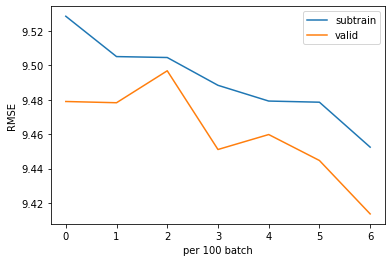

In [111]:
l = list(range(len(subtrain_rmse_list)))
plt.plot(l, subtrain_rmse_list, label='subtrain')
plt.plot(l, valid_rmse_list, label='valid')
plt.xlabel("per 100 batch")
plt.ylabel("RMSE")
plt.legend()
plt.show()

這張是後來只跑出一點點的圖。

In [112]:
net_d.load_state_dict(torch.load('./net/best_q5_H90.pkl'))
net_d.eval()
test_pred = net_d(X_test_torch)
test_rmse = np.sqrt(mean_squared_error(test_pred.detach().numpy(), Y_test_torch))

print("H = 90, test RMSE = ", test_rmse)

H = 90, test RMSE =  9.454007


(我不小心在檢查時重新按到了restart the kernel then re-run the whole notebook，且不知為何第一次10分鐘左右就能跑完的部分，跑了30分鐘只跑了600個batch(猜測原因為電腦超負荷，過熱所導致的)，最後因時間的限制下來不及重跑，只能憑印象寫下分析)

由圖可知，雖然兩者的RMSE都提高一些了，但是兩者的波動幅度較為平緩，且顯然valid RMSE的效果比起沒有drop out的版本更接近subtrain RMSE(較低)，因此可以知道加入drop out機制有助於穩定資料訓練的狀況，且在test上能有較好的預測表現(test RMSE = 8.7......)

#### Q6.

In [113]:
def training_q5(H):
    batch_cnt = 0
    best_step_cnt = 0
    early_stop = 0
    best_rmse = math.inf
    
    for epoch_id in range(0, nepoch): 
        for batch_idx, (inputs, targets) in enumerate(subtrainloader):
            #reshape target to two-dimensional array
            targets = targets.reshape((-1, 1))      
            net_d.train()
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer_q5.zero_grad()
            outputs = net_d(inputs)        
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer_q5.step()

            batch_cnt += 1
            best_step_cnt += 1
            if batch_cnt % 100 == 0:
                subtrain_pred = net_d(X_subtrain_torch)
                subtrain_rmse = np.sqrt(mean_squared_error(subtrain_pred.detach().numpy(), Y_subtrain_torch))
                valid_pred = net_d(X_valid_torch)
                valid_rmse = np.sqrt(mean_squared_error(valid_pred.detach().numpy(), Y_valid_torch))

                if valid_rmse < best_rmse:
                    best_step_cnt = 0
                    best_rmse = valid_rmse
                    torch.save(net_d.state_dict(), './net/best_q5_H'+str(H)+'.pkl')
            if best_step_cnt > 5000:
                print("best step cnt while early stop = ", best_step_cnt)
                print("batch cnt while early stop = ", batch_cnt)
                early_stop = 1
                break
        if early_stop == 1:
            break

In [114]:
H = [20, 45, 180, 360]
for h in H:
    training_q5(h)

KeyboardInterrupt: 

In [120]:
H = [20, 45, 180, 360]
for h in H:
    net_d.load_state_dict(torch.load('./net/best_q5_H'+str(h)+'.pkl'))
    net_d.eval()
    test_pred = net_d(X_test_torch)
    test_rmse = np.sqrt(mean_squared_error(test_pred.detach().numpy(), Y_test_torch))
    print('H = '+str(h)+', Test RMSE = '+str(test_rmse))

H = 20, Test RMSE = 9.26413
H = 45, Test RMSE = 9.291512


印象中最好的預測結果發生在H = 360，可以合理推測hidden nodes越多，drop out機制的效果越強大，當H太小的時候，0.5的drop out會使的剩餘的參數過少，因此對預測結果能力造成了反效果，比起沒有drop out的版本，預測效果反而降低了。

Q7.L2 + L1 loss

In [ ]:
藉由改變z，以改變L1 loss 和 L2 loss的比例，可以算出對於此資料集而言，何種線性組合的預測效果較佳

In [3]:
class l2_l1_loss(torch.nn.Module):
    def __init__(self, z):
        super().__init__()
        self.z = z
        
    def forward(self, x, y):
        return self.z * torch.sum(torch.pow((x - y), 2)) + (1 - self.z) * torch.sum(torch.abs(x - y))

NameError: name 'torch' is not defined

In [2]:
h = 90
batch_cnt = 0
best_step_cnt = 0
early_stop = 0
best_rmse = math.inf
loss_fn = l2_l1_loss(0.5)

subtrain_rmse_list = []
valid_rmse_list = []
    
for epoch_id in range(0, nepoch): 
    for batch_idx, (inputs, targets) in enumerate(subtrainloader):
        #reshape target to two-dimensional array
        targets = targets.reshape((-1, 1))      
        net_d.train()
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer_q5.zero_grad()
        outputs = net_d(inputs)        
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer_q5.step()

        batch_cnt += 1
        best_step_cnt += 1
        if batch_cnt % 100 == 0:
            subtrain_pred = net_d(X_subtrain_torch)
            subtrain_rmse = np.sqrt(mean_squared_error(subtrain_pred.detach().numpy(), Y_subtrain_torch))
            subtrain_rmse_list.append(subtrain_rmse)
            valid_pred = net_d(X_valid_torch)
            valid_rmse = np.sqrt(mean_squared_error(valid_pred.detach().numpy(), Y_valid_torch))
            valid_rmse_list.append(valid_rmse)

            if valid_rmse < best_rmse:
                best_step_cnt = 0
                best_rmse = valid_rmse
                torch.save(net_d.state_dict(), './net/best_q7_z'+str(0.5)+'.pkl')
        if best_step_cnt > 5000:
            print("best step cnt while early stop = ", best_step_cnt)
            print("batch cnt while early stop = ", batch_cnt)
            early_stop = 1
            break
    if early_stop == 1:
        break
print("batch cnt =", batch_cnt)

NameError: name 'l2_l1_loss' is not defined

In [ ]:
l = list(range(len(subtrain_rmse_list)))
plt.plot(l, subtrain_rmse_list, label='subtrain')
plt.plot(l, valid_rmse_list, label='valid')
plt.xlabel("per 100 batch")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [ ]:
net_d.load_state_dict(torch.load('./net/best_q7_z0.5.pkl'))
net_d.eval()
test_pred = net_d(X_test_torch)
test_rmse = np.sqrt(mean_squared_error(test_pred.detach().numpy(), Y_test_torch))

print("z = 0.5, test RMSE = ", test_rmse)

In [ ]:
def training_q7(z):
    h = 90
    batch_cnt = 0
    best_step_cnt = 0
    early_stop = 0
    best_rmse = math.inf
    loss_fn = l2_l1_loss(z)

    for epoch_id in range(0, nepoch): 
        for batch_idx, (inputs, targets) in enumerate(subtrainloader):
            #reshape target to two-dimensional array
            targets = targets.reshape((-1, 1))      
            net_d.train()
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer_q5.zero_grad()
            outputs = net_d(inputs)        
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer_q5.step()

            batch_cnt += 1
            best_step_cnt += 1
            if batch_cnt % 100 == 0:
                subtrain_pred = net_d(X_subtrain_torch
                valid_pred = net_d(X_valid_torch)
                valid_rmse = np.sqrt(mean_squared_error(valid_pred.detach().numpy(), Y_valid_torch))

                if valid_rmse < best_rmse:
                    best_step_cnt = 0
                    best_rmse = valid_rmse
                    torch.save(net_d.state_dict(), './net/best_q7_z'+str(z)+'.pkl')
            if best_step_cnt > 5000:
                print("best step cnt while early stop = ", best_step_cnt)
                print("batch cnt while early stop = ", batch_cnt)
                early_stop = 1
                break
        if early_stop == 1:
            break
    print("batch cnt =", batch_cnt)

In [ ]:
z_q7 = [0, 0.1, 0.9, 1]
for i in z_q7:
    net_d.load_state_dict(torch.load('./net/best_q7_z'+str(i)+'.pkl'))
    net_d.eval()
    test_pred = net_d(X_test_torch)
    test_rmse = np.sqrt(mean_squared_error(test_pred.detach().numpy(), Y_test_torch))

    print("z = ",i ," test RMSE = ", test_rmse)

L1的計算方式較不能適應各類型況，因此理論上z越接近0的時候，預測效果越差，越接近1效果越好，然而兩種loss function的線性組合，能夠彌補對方的缺點，因此效果通常會好過只用一種loss function，就此題使用的z參數而言，0.9應有最佳的預測效果

#### Q8 L2 + customized loss

藉由改變z，以改變customized loss 和 L2 loss的比例，可以算出對於此資料集而言，何種線性組合的預測效果較佳

In [ ]:
class Customerized(nn.Module):
    def __init__(self, z):
        super().__init__()
        self.z = z
        
    def forward(self, x, y):
        return self.z * torch.sum(torch.pow((x - y), 2)) + (1 - self.z) * torch.sum(0.5 * torch.clamp(x - y, min=0.0) + 0.5 * torch.clamp(y - x, min=0.0))

In [ ]:
h = 90
batch_cnt = 0
best_step_cnt = 0
early_stop = 0
best_rmse = math.inf
loss_fn = Customerized(0)

subtrain_rmse_list = []
valid_rmse_list = []
    
for epoch_id in range(0, nepoch): 
    for batch_idx, (inputs, targets) in enumerate(subtrainloader):
        #reshape target to two-dimensional array
        targets = targets.reshape((-1, 1))      
        net_d.train()
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer_q5.zero_grad()
        outputs = net_d(inputs)        
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer_q5.step()

        batch_cnt += 1
        best_step_cnt += 1
        if batch_cnt % 100 == 0:
            subtrain_pred = net_d(X_subtrain_torch)
            subtrain_rmse = np.sqrt(mean_squared_error(subtrain_pred.detach().numpy(), Y_subtrain_torch))
            subtrain_rmse_list.append(subtrain_rmse)
            valid_pred = net_d(X_valid_torch)
            valid_rmse = np.sqrt(mean_squared_error(valid_pred.detach().numpy(), Y_valid_torch))
            valid_rmse_list.append(valid_rmse)

            if valid_rmse < best_rmse:
                best_step_cnt = 0
                best_rmse = valid_rmse
                torch.save(net_d.state_dict(), './net/best_q8_z'+str(0)+'.pkl')
        if best_step_cnt > 5000:
            print("best step cnt while early stop = ", best_step_cnt)
            print("batch cnt while early stop = ", batch_cnt)
            early_stop = 1
            break
    if early_stop == 1:
        break
print("batch cnt =", batch_cnt)

In [ ]:
l = list(range(len(subtrain_rmse_list)))
plt.plot(l, subtrain_rmse_list, label='subtrain')
plt.plot(l, valid_rmse_list, label='valid')
plt.xlabel("per 100 batch")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [ ]:
net_d.load_state_dict(torch.load('./net/best_q8_z0.pkl'))
net_d.eval()
test_pred = net_d(X_test_torch)
test_rmse = np.sqrt(mean_squared_error(test_pred.detach().numpy(), Y_test_torch))

print("z = 0, test RMSE = ", test_rmse)

In [ ]:
def training_q8(z):
    h = 90
    batch_cnt = 0
    best_step_cnt = 0
    early_stop = 0
    best_rmse = math.inf
    loss_fn = Customerized(0)

    for epoch_id in range(0, nepoch): 
        for batch_idx, (inputs, targets) in enumerate(subtrainloader):
            #reshape target to two-dimensional array
            targets = targets.reshape((-1, 1))      
            net_d.train()
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer_q5.zero_grad()
            outputs = net_d(inputs)        
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer_q5.step()

            batch_cnt += 1
            best_step_cnt += 1
            if batch_cnt % 100 == 0:
                subtrain_pred = net_d(X_subtrain_torch)
                valid_pred = net_d(X_valid_torch)
                valid_rmse = np.sqrt(mean_squared_error(valid_pred.detach().numpy(), Y_valid_torch))


                if valid_rmse < best_rmse:
                    best_step_cnt = 0
                    best_rmse = valid_rmse
                    torch.save(net_d.state_dict(), './net/best_q8_z'+str(z)+'.pkl')
            if best_step_cnt > 5000:
                print("best step cnt while early stop = ", best_step_cnt)
                print("batch cnt while early stop = ", batch_cnt)
                early_stop = 1
                break
        if early_stop == 1:
            break
    print("batch cnt =", batch_cnt)

In [ ]:
z_q8 = [0.1, 0.5, 0.9, 1]
for i in z_q8:
    net_d.load_state_dict(torch.load('./net/best_q8_z'+str(i)+'.pkl'))
    net_d.eval()
    test_pred = net_d(X_test_torch)
    test_rmse = np.sqrt(mean_squared_error(test_pred.detach().numpy(), Y_test_torch))

    print("z = ",i ," test RMSE = ", test_rmse)

通常兩種loss function的線性組合能夠一定程度的彌補對方的缺點，因此很可能會好過只用一種loss function，而通常效果較好的loss function占比越大效果越好，因此就此題而言最佳預測效果可能發生在z = 0.1或0.9時。而印象中，Customerized loss似乎不太適合本題的資料集，因此預測效果最好的情況落在 z=0.1